##Installation


In [ ]:
!pip install keras
!pip install tensorflow
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import Libraries


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.utils 
import numpy as np
from PIL import Image
import os

import matplotlib.pyplot as plt
import pandas as pd
import keras
import cv2
import os
import math
import splitfolders
import itertools

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
#import gradio
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression


##Upload/Connect Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
input_dataset=('/content/drive/MyDrive/3 kinds of Pneumonia(dataset)(new)')

Mounted at /content/drive


#Dataset Analysis

In [ ]:
number_of_images = {}

for dir in os.listdir(input_dataset):
  number_of_images[dir] = len(os.listdir(os.path.join(input_dataset,dir)))

number_of_images.items()


dict_items([('COVID-19', 2000), ('Normal', 2000), ('Pneumonia-Viral', 2000), ('Pneumonia-Bacterial', 2000)])

##Dataset Bar Chart

##Splitting Dataset into Train, Validation and test

In [ ]:
from splitfolders.split import group_by_prefix
splitfolders.ratio(input_dataset,output="dataset",seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 8000 files [03:33, 37.44 files/s] 


In [ ]:
#%rm -rf '/content/drive/MyDrive/3 kinds of Pneumonia(dataset)'

#3.ResNet50 Model

## Data Preprocessing for ResNet50

In [ ]:
from keras.utils.image_dataset import image_dataset_from_directory
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as p3
def preprocessing_train3(path):
  image_data=ImageDataGenerator(preprocessing_function=p3,zoom_range=0.2,shear_range=0.2,horizontal_flip=True,vertical_flip=False)#data augmentation
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode="categorical")
  
  return image

In [ ]:
path_tr3='/content/dataset/train'
train_data=preprocessing_train3(path_tr3)#pre-processing training dataset

Found 5600 images belonging to 4 classes.


In [ ]:
def preprocessing3(path):
  image_data=ImageDataGenerator(preprocessing_function=p3)#data augmentation
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode="categorical")
  
  return image

In [ ]:
path_v3='/content/dataset/val'
val_data=preprocessing3(path_v3)#pre-processing validation dataset

Found 1600 images belonging to 4 classes.


In [ ]:
path_te3='/content/dataset/test'
test_data=preprocessing3(path_te3)

Found 800 images belonging to 4 classes.


In [ ]:
x_test, y_test = [], []
for i in range(len(test_data)):
    batch_x, batch_y = test_data[i]
    x_test.append(batch_x)
    y_test.append(batch_y)

# Concatenate the batches to obtain the final x_train and y_train arrays
x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Print the shape of the x_train and y_train arrays
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_test shape: (800, 224, 224, 3)
y_test shape: (800, 4)


##ResNet50 Model Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model,load_model
from keras.applications.resnet import ResNet50

In [ ]:
res=ResNet50(input_shape=(224,224,3),include_top=False)

In [ ]:
for layer in res.layers:
  layer.trainable=False

In [ ]:
x=Flatten()(res.output)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=4, activation='softmax')(x)

# prevent the weights from being updated during training
#res.trainable = False

res_model=Model(res.input,x)

In [ ]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
res_model.compile(optimizer = "adam" , 
            loss = 'categorical_crossentropy' , 
            metrics = ['accuracy'])

##ResNet50 Model Early stop and model check point

In [ ]:
#Early stopping

es3=EarlyStopping(monitor="val_accuracy", patience=20, verbose=1, mode="max")

#Model check point
mc3= ModelCheckpoint(monitor="val_accuracy", filepath="./Best_model3.h5", verbose=1, save_best_only=True, mode="max")
reduce_lr3 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.000000001)

cb3=[es3,mc3,reduce_lr3]


In [ ]:
m3=res_model.fit(train_data,steps_per_epoch=len(train_data),epochs=100,verbose=1,validation_data=(val_data),validation_steps=len(val_data),callbacks=cb3)

Epoch 1/100
175/175 [==============================] - ETA: 0s - loss: 4.1083 - accuracy: 0.7673
Epoch 1: val_accuracy improved from -inf to 0.78188, saving model to ./Best_model3.h5
175/175 [==============================] - 36s 182ms/step - loss: 4.1083 - accuracy: 0.7673 - val_loss: 1.3097 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8961
Epoch 2: val_accuracy improved from 0.78188 to 0.84562, saving model to ./Best_model3.h5
175/175 [==============================] - 35s 202ms/step - loss: 0.3425 - accuracy: 0.8961 - val_loss: 0.8436 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.9257
Epoch 3: val_accuracy improved from 0.84562 to 0.86063, saving model to ./Best_model3.h5
175/175 [==============================] - 40s 228ms/step - loss: 0.2386 - accuracy: 0.9257 - val_loss: 0.6834 - val_accuracy: 0.8606 - lr: 0.0010
Epoc

##Resnet50 Model Accuracy Graph

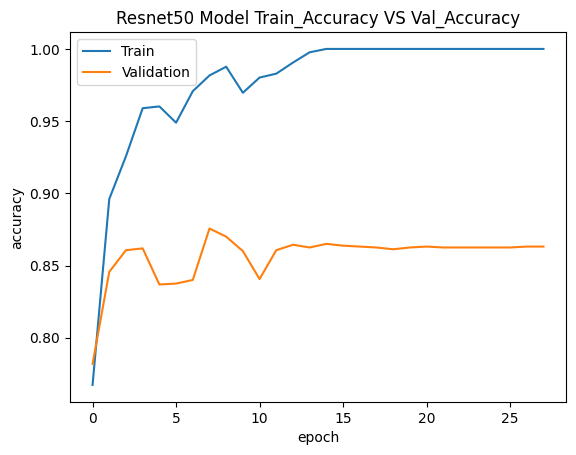

In [ ]:
plt.plot(m3.history['accuracy'])
plt.plot(m3.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title("Resnet50 Model Train_Accuracy VS Val_Accuracy")
plt.show()

##Resnet50 Model Loss Graph

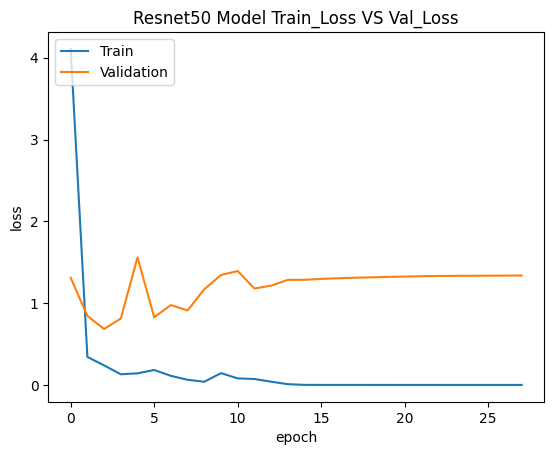

In [ ]:
plt.plot(m3.history['loss'])
plt.plot(m3.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title("Resnet50 Model Train_Loss VS Val_Loss")
plt.show()

##ResNet50 Model Accuracy

In [ ]:
model3=load_model('/content/Best_model3.h5')

In [ ]:
loss,acc=model3.evaluate(test_data)

In [ ]:
loss,acc=model3.evaluate(x_test,y_test)
print(f"The accuracy of ResNet50 model is {acc*100} % and loss is {loss}")

25/25 [==============================] - 4s 103ms/step - loss: 0.8855 - accuracy: 0.8725
The accuracy of ResNet50 model is 87.25000023841858 % and loss is 0.8854849934577942


##ResNet50 Model Percision, Recall, F1 Score

In [ ]:
y_pred = model3.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculating the confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)


25/25 [==============================] - 3s 97ms/step


In [ ]:
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.97      0.96      0.96       200
           2       0.79      0.74      0.76       200
           3       0.74      0.79      0.76       200

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



Normalized confusion matrix


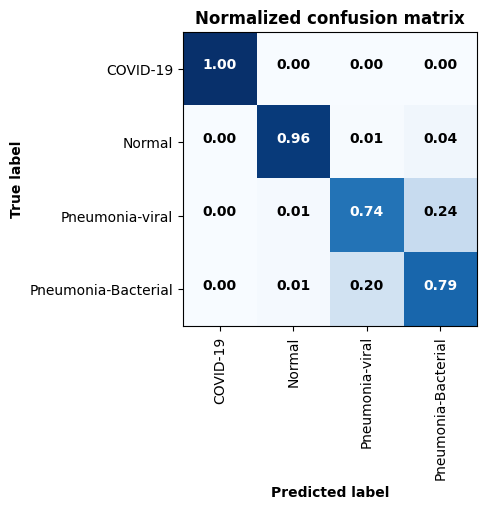

In [ ]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix without normalization")
  
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title,weight='bold')
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=90)
  plt.yticks(tick_marks,classes)


  fmt='.2f' if normalize else 'd'
  thresh=cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',weight='bold',
             color='white' if cm[i,j]> thresh else 'black')
  plt.tight_layout()
  plt.ylabel("True label", weight='bold')
  plt.xlabel("Predicted label",weight="bold")

#compute confusion matrix
cnf_matrix=confusion_matrix(y_true_classes, y_pred_classes)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['COVID-19','Normal','Pneumonia-viral','Pneumonia-Bacterial'],normalize=True,title="Normalized confusion matrix")
plt.show()